In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import fastai
from fastai.vision import*
from fastai.imports import *
from sklearn.metrics import fbeta_score
import warnings
import shutil, os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = '.../My Drive/AdvanceResearchMethods'

In [ ]:
# Data preparation steps if you are using Crestle:

os.makedirs('data/weather/models', exist_ok=True)
os.makedirs('data/weather/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/test-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [ ]:
!ls '.../My Drive/AdvanceResearchMethods'

ls: cannot access '/content/gdrive/My Drive/AdvanceResearchMethods': No such file or directory


In [ ]:
main_folder = '.../My Drive/AdvanceResearchMethods'
train_csv ='train.csv'
df=pd.read_csv(os.path.join(main_folder, train_csv))

In [ ]:
columns=['image_name','tag']
df.columns=columns
df

,image_name,tag
0,File_ID_2752_Front.mp4_frame_000095.jpg,"[day,rainy]"
1,File_ID_2752_Front.mp4_frame_000090.jpg,"[day,rainy]"
2,File_ID_2752_Front.mp4_frame_000085.jpg,"[day,rainy]"
3,File_ID_2752_Front.mp4_frame_000080.jpg,"[day,rainy]"
4,File_ID_2752_Front.mp4_frame_000075.jpg,"[day,rainy]"
...,...,...
446,File_ID_3953_Front.mp4_frame_000090.jpg,"[day,clear]"
447,File_ID_3953_Front.mp4_frame_000085.jpg,"[day,clear]"
448,File_ID_3953_Front.mp4_frame_000080.jpg,"[day,clear]"
449,File_ID_3953_Front.mp4_frame_000075.jpg,"[day,clear]"


In [ ]:
df['tag'].unique()

array(['[day,rainy]', '[night,clear]', '[day,clear]'], dtype=object)

In [ ]:
tfms = get_transforms(contrast(scale=(0.5, 2.), p=1.) ,brightness(change=(0.1, 0.9), p=1.0),max_zoom=1.1)

In [ ]:
np.random.seed(50)
src = (ImageList.from_csv(main_folder, train_csv, folder='train-jpg')
       .random_split_by_pct(0.3)
       .label_from_df(label_delim=';'))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [ ]:
print (src.valid)

LabelList (135 items)
x: ImageList
Image (3, 356, 480),Image (3, 356, 480),Image (3, 356, 480),Image (3, 356, 480),Image (3, 356, 480)
y: MultiCategoryList
[day,clear],[day,rainy],[night,clear],[night,clear],[day,clear]
Path: /content/gdrive/MyDrive/DEEPINSIGHT/multilabel


In [ ]:
import warnings
warnings.filterwarnings('ignore')
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

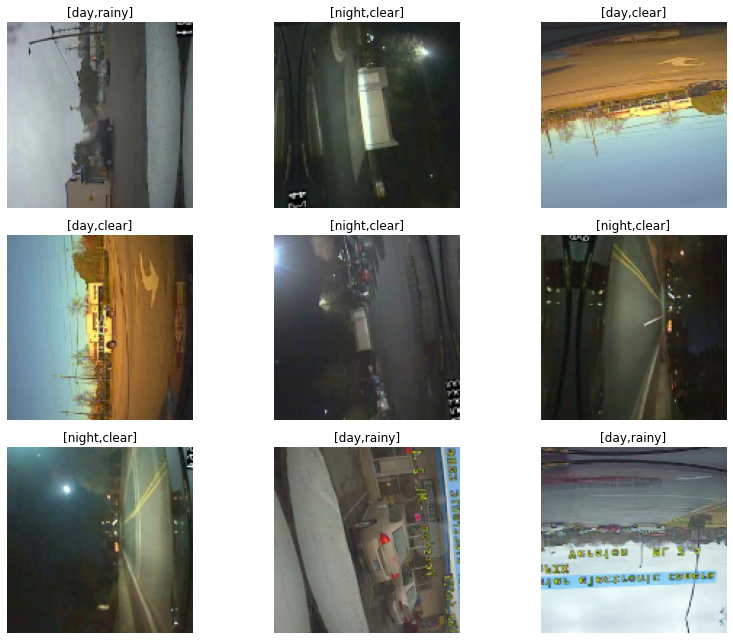

In [ ]:
data.show_batch(rows=3, figsize=(12,9))


In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


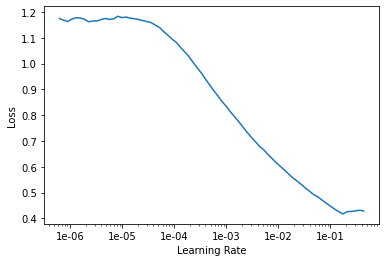

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.01

In [ ]:
learn.fit_one_cycle(25, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.771555,0.220980,0.767901,0.887302,01:05
1,0.499208,0.212921,0.881482,0.936155,00:05
2,0.382478,0.097497,0.967901,0.979012,00:05
3,0.300777,0.064185,0.987654,0.988889,00:05
4,0.253051,0.057867,0.990124,0.990124,00:05
5,0.213759,0.050313,0.987654,0.993827,00:05
6,0.191700,0.053452,0.992593,0.991358,00:05
7,0.167168,0.060979,0.995062,0.992593,00:05
8,0.147635,0.050301,0.995062,0.992593,00:05
9,0.133610,0.049328,0.995062,0.992593,00:05


In [ ]:
learn.save('stage-1-rn50')

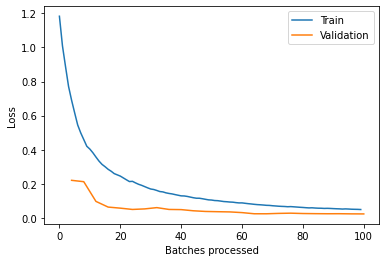

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# learn.unfreeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
# learn.recorder.plot_losses()

In [ ]:
multi_preds, y = learn.TTA()
#preds = torch.mean(multi_preds, 0)

In [ ]:
preds = torch.round(multi_preds)

In [ ]:
len(preds)

135

In [ ]:
from sklearn.metrics import confusion_matrix

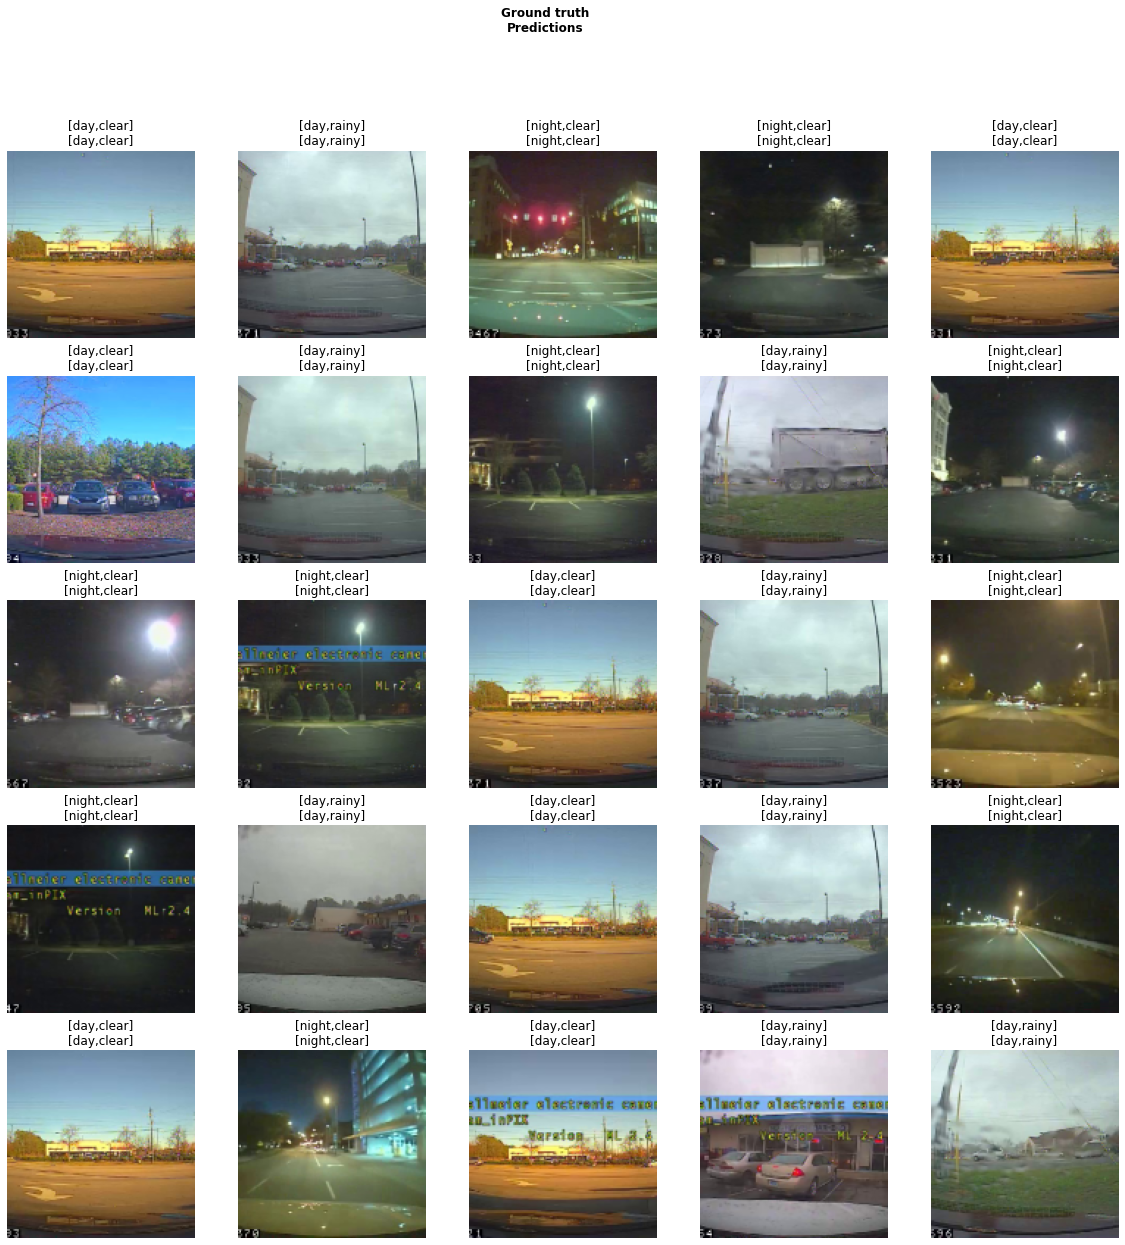

In [ ]:
learn.show_results()

In [ ]:
label_y = np.argmax(y, 1)
ground_truth = [data.classes[int(x)] for x in label_y]
labels_pred = np.argmax(multi_preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels_pred]

In [ ]:
labels_pred

tensor([0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1,
        1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2, 1,
        1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2,
        2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2,
        2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2])

In [ ]:
label_y

tensor([0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 0, 1,
        1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 2, 1, 1, 2, 1,
        1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
        2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2,
        2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

[[18  0  0]
 [ 0 56  0]
 [ 1  0 60]]


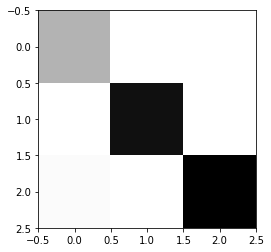

In [ ]:
cm=confusion_matrix(label_y,labels_pred)
print(cm)
plt.imshow(cm, cmap='binary')

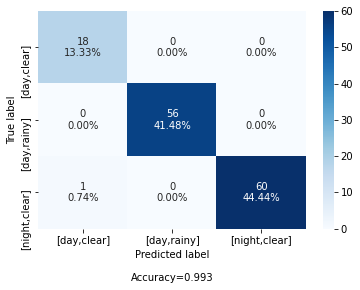

In [ ]:
categories = ['[day,clear]','[day,rainy]','[night,clear]']
make_confusion_matrix(cm,categories=categories)
                      

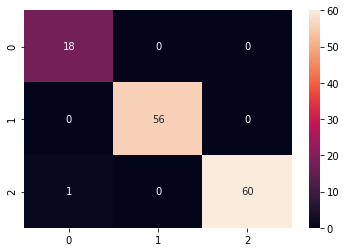

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [ ]:
learn.save('/content/gdrive/My Drive/AdvanceResearchMethods/final_model')

In [ ]:
learn.path

PosixPath('/content/gdrive/My Drive/AdvanceResearchMethods')

In [ ]:
learn.model_dir

'/tmp/models'